## Data Cleaning and Preparation
* `Dataset` - [SUPPORT2]("https://archive.ics.uci.edu/dataset/880/support2")

In [103]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score

from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import shapiro

import warnings
from google.colab import drive, files

sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

# Data Loading
The target variable $y =$ `hospdead`, where:
- *0* - successful recovery
- *1* - death in hospital

It is inportant to notice that $y$ is not normal distributed.

In [104]:
support2 = fetch_ucirepo(id=880)

data = support2.data.features
y = support2.data.targets

In [105]:

y = y.drop(["death", "sfdm2"], axis=1)
y.rename(columns={"hospdead" : "y_hospdead"}, inplace=True)

In [106]:
data  = data.join(y, how="right")

In [107]:
print(data.shape)
y.head()

(9105, 43)


,y_hospdead
0,0
1,1
2,0
3,0
4,0


In [108]:
y.value_counts()

,count
y_hospdead,
0,6745
1,2360


In [109]:
categories = ["sex", "dzgroup", "dzclass", "race", "ca", "dnr", "income"]
data[categories].head()

,sex,dzgroup,dzclass,race,ca,dnr,income
0,male,Lung Cancer,Cancer,other,metastatic,no dnr,$11-$25k
1,female,Cirrhosis,COPD/CHF/Cirrhosis,white,no,NaN,$11-$25k
2,female,Cirrhosis,COPD/CHF/Cirrhosis,white,no,no dnr,under $11k
3,female,Lung Cancer,Cancer,white,metastatic,no dnr,under $11k
4,female,ARF/MOSF w/Sepsis,ARF/MOSF,white,no,no dnr,NaN


In [110]:
data = pd.get_dummies(data, columns=categories, drop_first=True).astype(float)

In [111]:
data.head()

,age,num.co,edu,scoma,charges,totcst,totmcst,avtisst,sps,aps,...,race_hispanic,race_other,race_white,ca_no,ca_yes,dnr_dnr before sadm,dnr_no dnr,income_$25-$50k,income_>$50k,income_under $11k
0,62.84998,0.0,11.0,0.0,9715.0,NaN,NaN,7.000000,33.898438,20.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,60.33899,2.0,12.0,44.0,34496.0,NaN,NaN,29.000000,52.695312,74.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,52.74698,2.0,12.0,0.0,41094.0,NaN,NaN,13.000000,20.500000,45.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,42.38498,2.0,11.0,0.0,3075.0,NaN,NaN,7.000000,20.097656,19.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,79.88495,1.0,NaN,26.0,50127.0,NaN,NaN,18.666656,23.500000,30.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


## Handling Missing Values:
The main goal of this section is to fill *NaN* values. The following techniques were used:
- Columns where *NaN* values constituted over $50\%$ were removed.
- Columns with fewer than $200$ *NaN*'s were imputed with `mean` or `mode`.
- For all remaining columns, the `IterativeImputer` was applied. This imputer predicts *NaN* values based on other columns using `BayesianRidge` model.

In [112]:
data.isna().sum()[(data.isna().sum() > 0)==True]

,0
edu,1634
scoma,1
charges,172
totcst,888
totmcst,3475
avtisst,82
sps,1
aps,1
surv2m,1
surv6m,1


In [113]:
data_low_nan = data.loc[:, (data.isna().sum() < 200) == True]
data_low_nan.head()

,age,num.co,scoma,charges,avtisst,sps,aps,surv2m,surv6m,hday,...,race_hispanic,race_other,race_white,ca_no,ca_yes,dnr_dnr before sadm,dnr_no dnr,income_$25-$50k,income_>$50k,income_under $11k
0,62.84998,0.0,0.0,9715.0,7.000000,33.898438,20.0,0.262939,0.036995,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,60.33899,2.0,44.0,34496.0,29.000000,52.695312,74.0,0.001000,0.000000,3.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,52.74698,2.0,0.0,41094.0,13.000000,20.500000,45.0,0.790894,0.664917,4.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,42.38498,2.0,0.0,3075.0,7.000000,20.097656,19.0,0.698975,0.411987,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,79.88495,1.0,26.0,50127.0,18.666656,23.500000,30.0,0.634888,0.532959,3.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [114]:
for col in list(data_low_nan.columns):
  if col in categories:
    data_low_nan[col] = data_low_nan[col].fillna(data_low_nan[col].mode()[0])
  else:
    data_low_nan[col] = data_low_nan[col].fillna(data_low_nan[col].mean())


In [115]:
data.loc[:, (data.isna().sum() < 200) == True] = data_low_nan

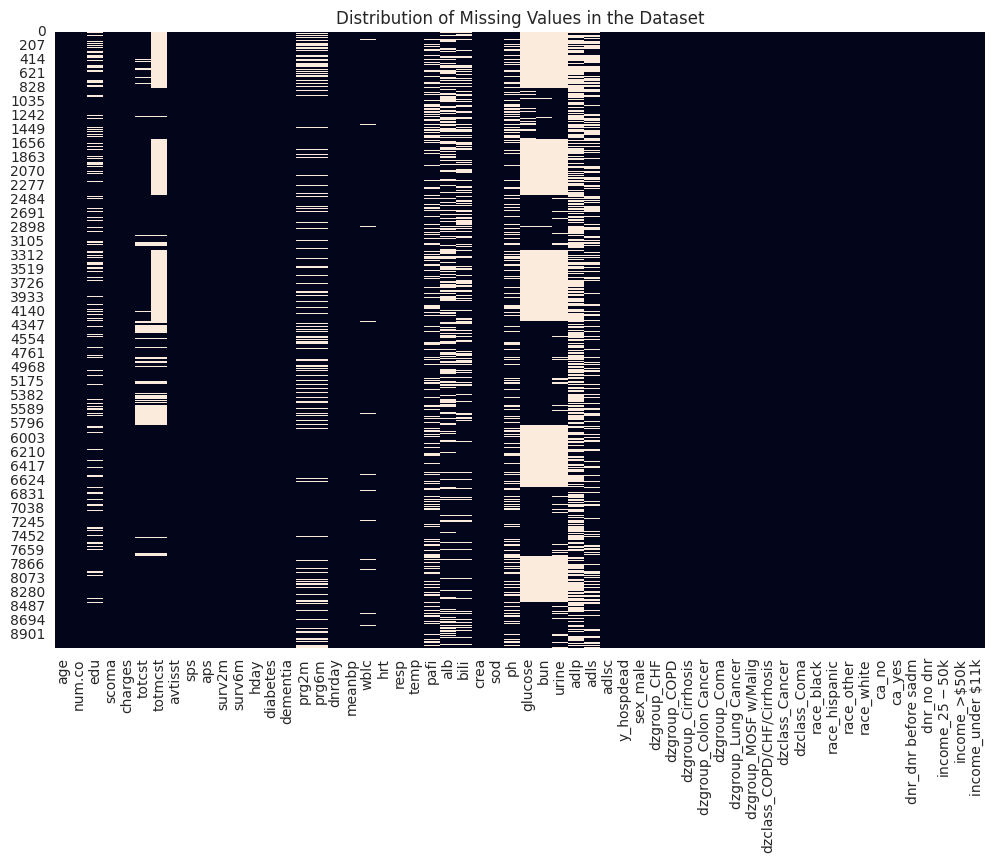

In [116]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    data=data.isna(),
    label = "Nan's Distribution in the Dataset",
    cbar=False
)
plt.title("Distribution of Missing Values in the Dataset");

In [117]:
data_w_nan = data.loc[:, data.isna().any()==True]

In [118]:
nan_ratio = {}
for col in data_w_nan.columns:
  nan_ratio[col] = sum(data_w_nan[col].isna()) / data_w_nan.shape[0]
pd.Series(nan_ratio, index=nan_ratio.keys()).sort_values(ascending=False)

,0
adlp,0.619550
urine,0.533992
glucose,0.494234
bun,0.477979
totmcst,0.381658
alb,0.370346
adls,0.314882
bili,0.285667
pafi,0.255354
ph,0.250851


In [119]:
data.drop(columns=["adlp", "urine"], inplace=True)

In [120]:
imputer = IterativeImputer(
    max_iter=20,
    random_state=777,
    verbose=1,
)

In [121]:
imputer_data_array = imputer.fit_transform(data)

[IterativeImputer] Completing matrix with shape (9105, 56)
[IterativeImputer] Change: 742808.8428232457, scaled tolerance: 1435.423 
[IterativeImputer] Change: 26147.386105722457, scaled tolerance: 1435.423 
[IterativeImputer] Change: 18990.626472705713, scaled tolerance: 1435.423 
[IterativeImputer] Change: 13580.508376320358, scaled tolerance: 1435.423 
[IterativeImputer] Change: 9709.67048689432, scaled tolerance: 1435.423 
[IterativeImputer] Change: 6937.572924082138, scaled tolerance: 1435.423 
[IterativeImputer] Change: 4952.3867045085935, scaled tolerance: 1435.423 
[IterativeImputer] Change: 3581.4091167001084, scaled tolerance: 1435.423 
[IterativeImputer] Change: 2601.812131358169, scaled tolerance: 1435.423 
[IterativeImputer] Change: 1890.1640390698426, scaled tolerance: 1435.423 
[IterativeImputer] Change: 1373.0832140979921, scaled tolerance: 1435.423 
[IterativeImputer] Early stopping criterion reached.


In [122]:
df = pd.DataFrame(imputer_data_array, columns=data.columns)
df.head()

,age,num.co,edu,scoma,charges,totcst,totmcst,avtisst,sps,aps,...,race_hispanic,race_other,race_white,ca_no,ca_yes,dnr_dnr before sadm,dnr_no dnr,income_$25-$50k,income_>$50k,income_under $11k
0,62.84998,0.0,11.00000,0.0,9715.0,5393.834169,5665.349535,7.000000,33.898438,20.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,60.33899,2.0,12.00000,44.0,34496.0,35162.795550,34666.104343,29.000000,52.695312,74.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,52.74698,2.0,12.00000,0.0,41094.0,25301.338097,25428.178596,13.000000,20.500000,45.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,42.38498,2.0,11.00000,0.0,3075.0,-3134.754190,-2640.951053,7.000000,20.097656,19.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,79.88495,1.0,11.74304,26.0,50127.0,25960.056653,26280.570231,18.666656,23.500000,30.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [123]:
df.isna().sum().sum()

np.int64(0)

## Exploratory Data Analysis
- A correlation matrix was made to understand the relationships between features and the dependent variable `y`
- The data was splitted to `X` and `y`.


The Shapiro-Wilk test confirmed that all `X`'s columns were not normally distributed. Result is particularly important in the context of using the Gaussian Naive Bayes classifier.

In [124]:
corr = df.corr()
corr.y_hospdead.apply(np.abs).sort_values(ascending=False).head()

,y_hospdead
y_hospdead,1.000000
dnr_no dnr,0.566552
surv2m,0.558024
avtisst,0.551099
prg2m,0.545233


<Axes: >

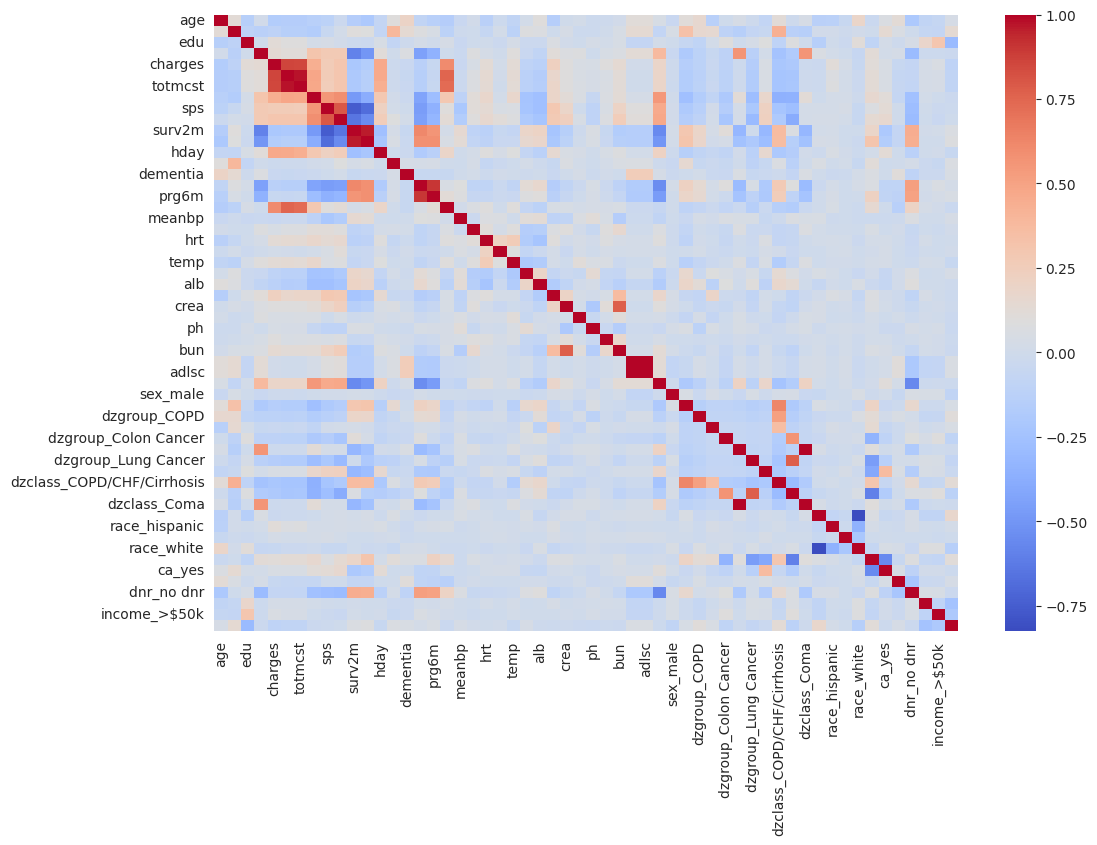

In [125]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    data=corr,
    cmap="coolwarm"
)

In [126]:
y.value_counts(normalize=True)

,proportion
y_hospdead,
0,0.740802
1,0.259198


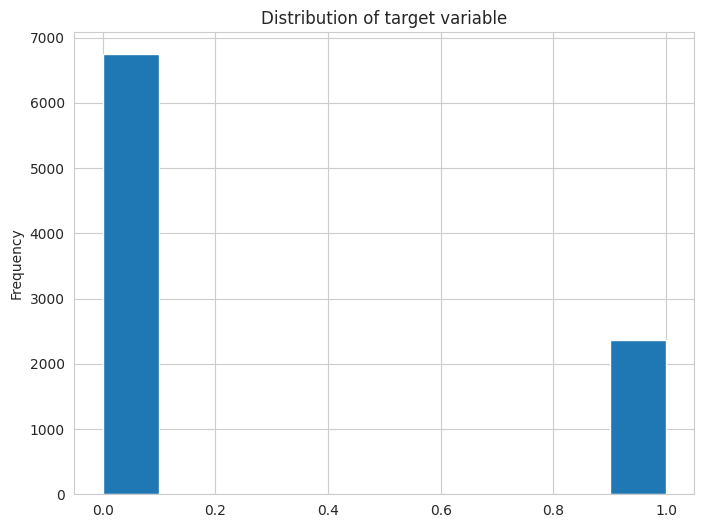

In [127]:
plt.figure(figsize=(8, 6))
plt.title("Distribution of target variable")
df.y_hospdead.plot.hist();

In [128]:
drive.mount("/content/data")

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [129]:
import os
folder_path = '/content/drive/My Drive/In_hospital_mortality_Prediction'
file_name = 'in_hospital_mortality_data.csv'

os.makedirs(folder_path, exist_ok=True)

full_path = os.path.join(folder_path, file_name)

df.to_csv(full_path, index=False)
#files.download(full_path)

In [130]:
X = df.drop("y_hospdead", axis=1)
y = df.y_hospdead
X.shape

(9105, 55)

Hypotheses for the Shapiro-Wilk test:


$H_0$: `p_val` $> 0.05$: The data is normally distributed.

$H_1$: `p_val` $< 0.05$: The data is not normally distributed.

In [131]:
stat_dict = {}
p_val_dict = {}
for col in list(X.columns):
  sample = X[col].sample(len(X[col]))
  stat, p_val = shapiro(sample)
  stat_dict[col] = stat
  p_val_dict[col] = p_val


In [132]:
p_val_scores=pd.Series(p_val_dict)
p_val_scores[(p_val_scores < 0.05)==True].shape


(55,)

$H_0$ is rejected - all feature has `p_val` $<0.05$

## Model Training and Evaluation
The data was split into training and testing sets. Three classification models were implemented using Pipelines:

* `LDA` with *Logistic Regression*: Data was scaled, dimensionality was reduced, and then a *Logistic Regression* classifier was applied.

* *Random Forest*: A *Random Forest Classifier* was used with tuned hyperparameters.

* *Gaussian Naive Bayes*: Data was transformed using `PowerTransformer` before being fed into a *Gaussian Naive Bayes* model. The `PowerTransformer` applies a to the data to stabilize variance and make its distribution more Gaussian-like (closer to a bell curve), which helps meet the core assumption of the *GaussianNB* classifier.

* *K-Nearest Neighbor*: Data was scaled and dimesionality was reduced.

Hyperparameter tuning was performed for the *Random Forest* model using `GridSearchCV` to find the optimal `n_estimators` and `max_depth` based on the
`recall` score.



In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [134]:
pipe_2 = Pipeline(
    [("scaler", StandardScaler()),
      ("lda", LDA(n_components=1)),
      ("log_reg", LogisticRegression(class_weight="balanced", random_state=777))])

pipe_3 = make_pipeline(RandomForestClassifier(class_weight="balanced", random_state=777))

pipe_4 = Pipeline([
    ("power_transform", PowerTransformer()),
    ("naive_bayes", GaussianNB())])
pipe_5 = Pipeline([("scaler", StandardScaler()),
      ("lda", LDA(n_components=1)),
      ("kneighbors", KNeighborsClassifier())])


In [135]:
params1 = {
  "randomforestclassifier__n_estimators" : [50, 100, 150, 200],
  "randomforestclassifier__max_depth" : [None, 10, 15, 20, 30]
}
grd1 = GridSearchCV(
    estimator=pipe_3,
    param_grid=params1,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='recall'

)

In [136]:
params2 = {
    "kneighbors__n_neighbors" : [5, 10, 15, 20],
    "kneighbors__weights" : ["uniform", "distance"]
}

grd2 = GridSearchCV(
    estimator=pipe_5,
    param_grid=params2,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='recall'

)

In [137]:
grd1.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=777))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [None, 10, 15, 20,
                                                               30],
                         'randomforestclassifier__n_estimators': [50, 100, 150,
                                                                  200]},
             scoring='recall', verbose=2)

In [138]:
grd2.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lda',
                                        LinearDiscriminantAnalysis(n_components=1)),
                                       ('kneighbors', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighbors__n_neighbors': [5, 10, 15, 20],
                         'kneighbors__weights': ['uniform', 'distance']},
             scoring='recall', verbose=2)

In [139]:
grd1.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 200}

In [140]:
grd2.best_params_

{'kneighbors__n_neighbors': 5, 'kneighbors__weights': 'uniform'}

In [141]:
grd1_results = pd.DataFrame(grd1.cv_results_)
grd1_results[["param_randomforestclassifier__max_depth", "param_randomforestclassifier__n_estimators", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head()

,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,mean_test_score
7,10,200,0.812085
6,10,150,0.810272
5,10,100,0.808459
4,10,50,0.807251
10,15,150,0.764955


In [142]:
pipe_3 = make_pipeline(RandomForestClassifier(class_weight="balanced", max_depth=10, n_estimators=200, random_state=77))
pipe_3.fit(X_train, y_train)
y_pred_random_forest = pipe_3.predict(X_test)
results_random_forest_best_params = classification_report(y_pred=y_pred_random_forest, y_true=y_test)
print(results_random_forest_best_params)

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93      2027
         1.0       0.80      0.82      0.81       705

    accuracy                           0.90      2732
   macro avg       0.87      0.87      0.87      2732
weighted avg       0.90      0.90      0.90      2732



In [143]:
pipe_5 = Pipeline([("scaler", StandardScaler()),
      ("lda", LDA(n_components=1)),
      ("kneighbors", KNeighborsClassifier(n_neighbors=5, weights="uniform"))])

pipe_5.fit(X_train, y_train)
y_pred_kneighbors = pipe_5.predict(X_test)
results_kneighbors_best_params = classification_report(y_pred=y_pred_kneighbors, y_true=y_test)
print(results_kneighbors_best_params)

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92      2027
         1.0       0.80      0.75      0.77       705

    accuracy                           0.89      2732
   macro avg       0.86      0.84      0.85      2732
weighted avg       0.89      0.89      0.89      2732



In [144]:
pipe_2.fit(X_train, y_train)
y_pred_log_regression = pipe_2.predict(X_test)
results_log_regression = classification_report(y_pred=y_pred_log_regression, y_true=y_test)
print(results_log_regression)

              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92      2027
         1.0       0.73      0.87      0.79       705

    accuracy                           0.88      2732
   macro avg       0.84      0.88      0.86      2732
weighted avg       0.89      0.88      0.89      2732



In [145]:
pipe_4.fit(X_train, y_train)
y_pred_bayes = pipe_4.predict(X_test)
results_bayes = classification_report(y_pred=y_pred_bayes, y_true=y_test)
print(results_bayes)

              precision    recall  f1-score   support

         0.0       0.92      0.80      0.85      2027
         1.0       0.58      0.80      0.67       705

    accuracy                           0.80      2732
   macro avg       0.75      0.80      0.76      2732
weighted avg       0.83      0.80      0.81      2732



In [146]:
def y_eval(y_true:pd.Series, y_pred:pd.Series):
  y_eval = pd.DataFrame(y_test).join(pd.Series(y_pred, name=f"{y_pred}", index=y_test.index), how="right")
  y_eval.columns = ["y_test", "y_pred"]
  return y_eval

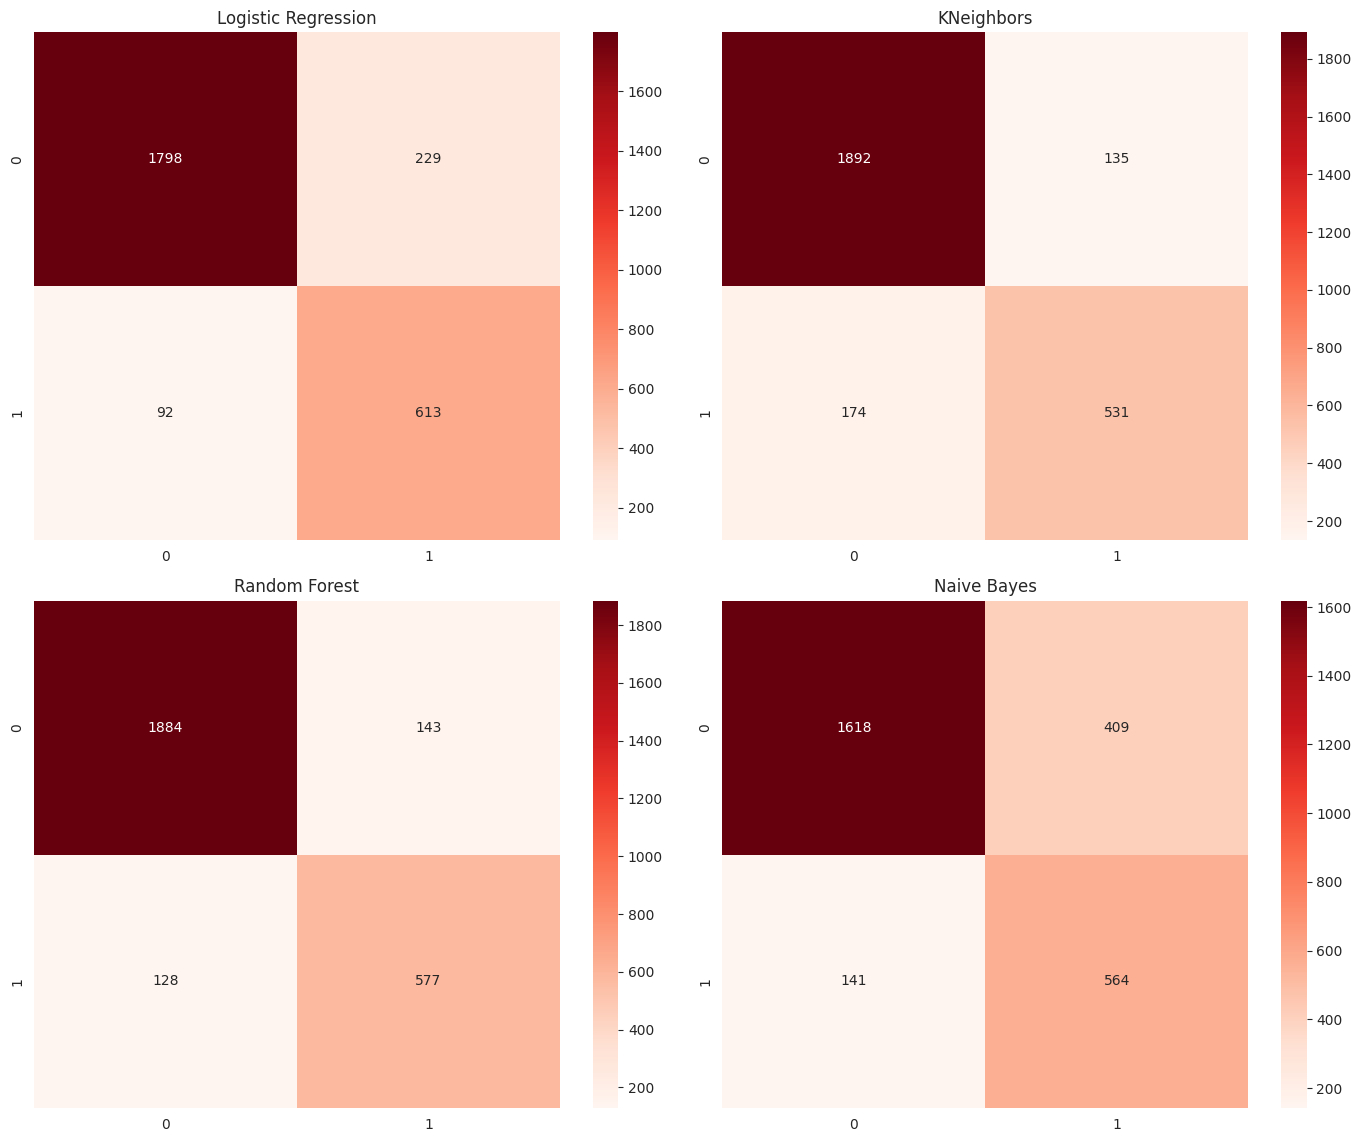

In [159]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.heatmap(ax=axes[0, 0],
            data=confusion_matrix(y_test, y_pred_log_regression),
            annot=True, cmap="Reds", fmt="d")
axes[0, 0].set_title("Logistic Regression")

sns.heatmap(ax=axes[0, 1],
            data=confusion_matrix(y_test, y_pred_kneighbors),
            annot=True, cmap="Reds", fmt="d")
axes[0, 1].set_title("KNeighbors")

sns.heatmap(ax=axes[1, 0],
            data=confusion_matrix(y_test, y_pred_random_forest),
            annot=True, cmap="Reds", fmt="d")
axes[1, 0].set_title("Random Forest")

sns.heatmap(ax=axes[1, 1],
            data=confusion_matrix(y_test, y_pred_bayes),
            annot=True, cmap="Reds", fmt="d")
axes[1, 1].set_title("Naive Bayes")
plt.tight_layout(rect=[0, 0, 1, 0.96])

In [156]:
model_scores = {
    'Model': ['Random Forest', 'Logistic Regression', 'Naive Bayes', "KNeighbors"],
    'Recall Score': [
        recall_score(y_true=y_test, y_pred=y_pred_random_forest),
        recall_score(y_true=y_test, y_pred=y_pred_log_regression),
        recall_score(y_true=y_test, y_pred=y_pred_bayes),
        recall_score(y_true=y_test, y_pred=y_pred_kneighbors)
    ],
    'Accuracy Score': [
        accuracy_score(y_true=y_test, y_pred=y_pred_random_forest),
        accuracy_score(y_true=y_test, y_pred=y_pred_log_regression),
        accuracy_score(y_true=y_test, y_pred=y_pred_bayes),
        accuracy_score(y_true=y_test, y_pred=y_pred_kneighbors)
    ]
}
scores = pd.DataFrame(model_scores)
scores

,Model,Recall Score,Accuracy Score
0,Random Forest,0.818440,0.900805
1,Logistic Regression,0.869504,0.882504
2,Naive Bayes,0.800000,0.798682
3,KNeighbors,0.753191,0.886896


## Summary
Given that the in-hospital death class is one quarter of the target data, *Logistic Regression* is the best-performing model.

In imbalanced dataset, `recall` is a more critical metric than `accuracy` because the cost of failing to predict a death (a false negative) is very high.

- *Logistic Regression* - the most effective model with highest recall ($0.869$)
- *Random Forest Classifier* - a lower recall and the highest accuracy
($0.900$) indicates it is less effective at identifying the minority class
- *Naive Bayes* - This model offered a solid, balanced performance with a good recall score ($0.800$).
- *KNeighbors* - Performed the poorest. It had the lowest recall ($0.753$), and despite its high accuracy, this makes it the least suitable model.